[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dina-lab3D/tutorials/blob/main/Fold-Dock/Fold_Dock.ipynb)



#Fold&Dock
Fold&Dock is a deep-learning based folding and docking tool that given an antibody sequence and an antigen structure produces their complex structure.
It provides several models, and ranks them using a deep-learning based scoring function.

Fold&Dock can be used to predict structures of nanobodies and mAbs (with or without an antigen).

<br>
<img src=https://drive.google.com/uc?id=1FUTKK5IZPNxNvi-aHA5vcQ0Pe_ba4B6h width="1000">


<strong>For Citations please use: </strong> [paper](https://www.mlsb.io/papers_2022/End_to_end_accurate_and_high_throughput_modeling_of_antibody_antigen_complexes.pdf)


#Docking nanobody with a SAXS profile of a complex
We will use Fold&Dock to generate complex models followed by ranking using a SAXS profile. We will dock a nanobody to Plasminogen Activator Inhibitor-1 (PDB 6zrv). The SAXS profile is from the SASBDB entry SASDJW5.
<br>
<img src="https://drive.google.com/uc?export=view&id=1J6FA12dZKcf7ydSQdnFo8b7bwi-NehB5" width="300">
<img src="https://drive.google.com/uc?export=view&id=1J83QaZWoK1Xi2-dqt7o8jdImcJ8HDJf-" width="150">
<img src="https://modbase.compbio.ucsf.edu/foxs/html/img/logo2.gif" width="150">
<br>


In [1]:
#@title install dependencies and clone the Fold&Dock trained model
import os
from IPython.display import clear_output

if not os.path.exists('FoldDockReady'):
  !pip -q install biopython
  !pip -q install py3Dmol
  !pip install -q scipy
  !pip install -q tensorflow


!touch FoldDockReady

# download model
if not os.path.exists("tutorials/Fold-Dock/" ):
  !git clone https://github.com/dina-lab3D/tutorials.git --quiet
  !unzip tutorials/Fold-Dock/DockModel.zip -d tutorials/Fold-Dock/DockModel

clear_output()

In [2]:

#@title Input antibody sequence


from google.colab import files
import re
import os
from IPython.display import clear_output


input_type = 'Fasta file' #@param ["Sequence (String)", "Fasta file"]
antibody_sequence = '' #@param {type:"string"}

if input_type == "Fasta file":
  uploaded_ab = files.upload()
  antibody_sequence = uploaded_ab.keys()
  if len(antibody_sequence) > 1:
    raise ValueError("Please upload a single fasta file, for multiple sequences in a single run put each antibody sequence in a different entry in the fasta file.")
  antibody_sequence = list(antibody_sequence)[0]


#@markdown  **Note**: use **':'** in order to seperate the heavy and light chains. **heavy chain should come first!**

#@markdown **Note**: you can model multiple antibody sequences for a single antigen by seperating them to different entries in the fasta file.


# get NanoNet trained model path

if input_type == 'Sequence (String)':
  # remove whitespaces
  antibody_sequence = "".join(antibody_sequence.split())
  antibody_sequence = re.sub(r'[^a-zA-Z:]','', antibody_sequence).upper()
  with open("input_fasta.fa", "w") as fa_file:
    fa_file.write("> model\n")
    fa_file.write("{}\n".format(antibody_sequence))
  antibody_sequence = "input_fasta.fa"

if not os.path.exists(antibody_sequence):
  raise ValueError("can't find fasta file {}.".format(antibody_sequence))




Saving nb.fasta to nb.fasta


In [3]:
#@title Input antigen structure
#@markdown  If you want to also perform docking run this cell after checking "do_docking" and upload the antigen PDB file (Can have multiple chains).

do_docking = True #@param {type:"boolean"}
antigen_chains = 'all' #@param {type:"string"}
uploaded_antigen = None

if do_docking:
  uploaded_antigen = files.upload()
  uploaded_antigen = uploaded_antigen.keys()
  if len(uploaded_antigen) > 1:
    raise ValueError("Please upload a single pdb file")
  uploaded_antigen = list(uploaded_antigen)[0]
  antigen_chains.replace(" ", "").replace(",", "")
  if not antigen_chains.isalpha():
    raise ValueError("Please use valid chain identifiers ([A-Z,a-z])")

specify_ag_chains = True
if antigen_chains.lower() == "all" or antigen_chains == "":
  specify_ag_chains = False


#@markdown If you need only some of the antigen chains for docking, specify them without spaces ('ABC' for example).

#@markdown **Note**: We currently support antigens with sequence length of up to 600 amino acids.



Saving 6zrvA.pdb to 6zrvA.pdb


In [4]:

#@markdown ---
#@markdown ### Advanced settings
top_n_pdb_models_to_create = 5 #@param {type:"integer"}
reconsrtuct_side_chains_using_modeller = True #@param {type:"boolean"}
modeller_license_key = 'MODELIRANJE' #@param {type:"string"}
fast_modeller = True #@param {type:"boolean"}
visualize_results = True #@param {type:"boolean"}
verbose = True #@param {type:"boolean"}

#@markdown ---
#@markdown ### Saving options
output_dir = 'Results' #@param {type:"string"}
# remove whitespaces
output_dir = "".join(output_dir.split())
output_dir = re.sub(r'\W+', '', output_dir)
save_to_google_drive = False #@param {type:"boolean"}
#@markdown ---
if top_n_pdb_models_to_create is None:
  top_n_pdb_models_to_create = 0

if top_n_pdb_models_to_create < 0:
  raise ValueError("Please insert a non-negative number of pdb models to create!")


if reconsrtuct_side_chains_using_modeller and modeller_license_key == '':
  raise ValueError("Please insert a valid license key!, you can get one from here: https://salilab.org/modeller/registration.html")

if save_to_google_drive == True:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("Saving results into Drive")


In [5]:
#@title Download Modeller
#@markdown If 'reconsrtuct_side_chains_using_modeller' is set to false, you can skip this step.
if not os.path.exists("ModellerReady") and reconsrtuct_side_chains_using_modeller:
  #@markdown **You can get a license key for Modeller from** **[here](https://salilab.org/modeller/registration.html)** .
  # modeller_license_key = '' #@param {type:"string"}
  #MODELIRANJE
  !wget https://salilab.org/modeller/10.1/modeller-10.1.tar.gz
  !tar -zxf modeller-10.1.tar.gz
  print("MODELLER extraction completed")
  %cd modeller-10.1
  #And we prepare a file containing the minimal setup elements
  #For installing, including a license key
  with open('modeller_config', 'a') as f:
    f.write("3\n")
    f.write("/content/compiled/MODELLER\n")
  #ADD YOUR LICENSE KEY HERE!
    f.write(f"{modeller_license_key}\n")
  !./Install < modeller_config
  print("MODELLER set up completed")

  %cd /content/
  #Creating a symbolic link
  %cd modeller-10.1
  !ln -sf /content/compiled/MODELLER/bin/mod10.1 /usr/bin/
  %cd /content/
  #Checking if MODELLER works
  !mod10.1 | awk 'NR==1{if($1=="usage:") print "MODELLER succesfully installed"; else if($1!="usage:") print "Something went wrong. Please install again"}'

  with open("/content/compiled/MODELLER/modlib/modeller/config.py", "r") as file:
    lines = file.readlines()

  with open("/content/compiled/MODELLER/modlib/modeller/config.py", "w") as file:
    file.write(lines[0])
    file.write(f"license = '{modeller_license_key}'\n")
  with open("ModellerReady","w"):pass
  clear_output()


In [6]:
#@title Predict antibody-antigen complexes
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
import logging
logging.getLogger('tensorflow').disabled = True

os.chdir("/content/")

flags = ""
if do_docking:
  flags+=f" -a {uploaded_antigen}"
if specify_ag_chains:
  flags+=f" -c {antigen_chains}"
if reconsrtuct_side_chains_using_modeller:
  flags+=" -m"
if fast_modeller:
  flags+=" -f"

flags+=f" -v {1 if verbose else 0} -o {output_dir} -t {top_n_pdb_models_to_create}"

if reconsrtuct_side_chains_using_modeller:
  !/content/compiled/MODELLER/bin/modpy.sh python tutorials/Fold-Dock/fold_dock.py $antibody_sequence $flags
else:
  !python tutorials/Fold-Dock/fold_dock.py $antibody_sequence $flags


Loading the trained models
INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:Fingerprint not found. Saved model loading will continue.
Making the antigen input
Working on sequence 1/1
Making the antibody input
Predicting the antibody-antigen complexes
9/9 [==============================] - 27s 918ms/step
Calculating scores for the antibody-antigen complexes
9/9 [==============================] - 6s 300ms/step
Finished running Fold&Dock, best complex model score: -5.2284
Creating PDB files for the top 5 models
Created PDB file nb_rank_1_unrelaxed.pdb
Relaxing PDB file nb_rank_1_unrelaxed.pdb using MODELLER
Created relaxed PDB file
Created PDB file nb_rank_2_unrelaxed.pdb
Relaxing PDB file nb_rank_2_unrelaxed.pdb using MODELLER
Created relaxed PDB file
Created PDB file nb_rank_3_unrelaxed.pdb
Relaxing PDB file nb_rank_3_unrelaxed.pdb using MODELLER
Created relaxed PDB file
Created PDB file nb_

In [ ]:
#@title Visualize the best scoring complex (for each of the antibody sequences)
import py3Dmol
import pandas as pd
import sys
if '/content/tutorials/Fold-Dock' not in sys.path:
  sys.path.insert(0, '/content/tutorials/Fold-Dock')
  from utils import seq_iterator

color_list = ["aquamarine","black","blue","bluewhite","brightorange","brown",
              "carbon","chartreuse","chocolate","cyan","darksalmon","dash","deepblue","deepolive",
              "deeppurple","deepsalmon","deepteal","density","dirtyviolet","firebrick","forest","gray",
              "green","greencyan","hotpink","hydrogen","lightblue","lightmagenta","lightorange","lightpink",
              "lightteal","lime","limegreen	","limon","magenta","marine","nitrogen","olive",
              "orange", "oxygen", "palecyan", "palegreen", "paleyellow", "pink", "purple", "purpleblue", "raspberry",
              "red", "ruby", "salmon", "sand", "skyblue", "slate", "smudge", "splitpea", "sulfur", "teal", "tv_blue",
              "tv_green", "tv_orange", "tv_red", "tv_yellow", "violet", "violetpurple", "warmpink", "wheat", "yellow", "yelloworange"]

ids_list = [*"ABCDEFGHIJKLMNOPQRSTUVWXYZ"] + [*"abcdefghijklmnopqrstuvwxyz"]


def plot_structure(ab_name, score, pdb_path):
    with open(pdb_path) as ifile:
      predicted = "".join([x for x in ifile])
    r,g,b = 0,0,255
    print(f"\033[38;2;{r};{g};{b}m {ab_name} Predicted model, Score: {score}\033[38;2;255;255;255m")
    view = py3Dmol.view(width=500, height=500)
    view.addModelsAsFrames(predicted)
    view.setStyle({'model': 0}, {"cartoon": {'arrows':True, 'color': 'blue'}})
    for chain_id, chain_color in zip(ids_list, color_list):
      view.setStyle({'chain':chain_id},{'cartoon': {'color':chain_color}})
    view.zoomTo()
    view.show()



file_ending = "unrelaxed.pdb" if not reconsrtuct_side_chains_using_modeller else "relaxed.pdb"
if visualize_results:
  print("Showing Fold&Dock best scoring predicted structure")
  for ab_seq_obj in seq_iterator(antibody_sequence):
    complex_score = "-"
    if do_docking:
      complex_score = pd.read_csv(os.path.join(output_dir, ab_seq_obj.id, "scores.csv"))["score"][0]
    plot_structure(ab_seq_obj.id, complex_score, os.path.join(output_dir, ab_seq_obj.id, f"{ab_seq_obj.id}_rank_1_{file_ending}"))

In [ ]:
#@title Download results


!zip -FSr $output_dir".zip" $output_dir
files.download(f"{output_dir}.zip")

if save_to_google_drive == True and drive != None:
  uploaded = drive.CreateFile({'title': f"{output_dir}.zip"})
  uploaded.SetContentFile(f"{output_dir}.zip")
  uploaded.Upload()
  print(f"Uploaded {output_dir}.zip to Google Drive with ID {uploaded.get('id')}")

In [13]:
#@title IMP installation is needed for SAXS. We will use FoXS from IMP to compare complexes to SAXS profiles
!echo "deb https://integrativemodeling.org/latest/download $(lsb_release -cs)/" > /etc/apt/sources.list.d/salilab.list
!wget -O /etc/apt/trusted.gpg.d/salilab.asc https://salilab.org/~ben/pubkey256.asc
!apt update
!apt install imp gnuplot
import sys, os, glob
sys.path.append(os.path.dirname(glob.glob('/usr/lib/python*/dist-packages/IMP')[0]))

--2023-09-18 11:22:16--  https://salilab.org/~ben/pubkey256.asc
Resolving salilab.org (salilab.org)... 169.230.79.19
Connecting to salilab.org (salilab.org)|169.230.79.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3122 (3.0K) [text/plain]
Saving to: ‘/etc/apt/trusted.gpg.d/salilab.asc’

/etc/apt/trusted.gp 100%[===================>]   3.05K  --.-KB/s    in 0s      

2023-09-18 11:22:16 (1.60 GB/s) - ‘/etc/apt/trusted.gpg.d/salilab.asc’ saved [3122/3122]

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://integrativemodeling.org/latest/download jammy/ InRelease [1,779 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 https://

Saving SASDJW5.dat to SASDJW5 (7).dat
SASDJW5 (7).dat


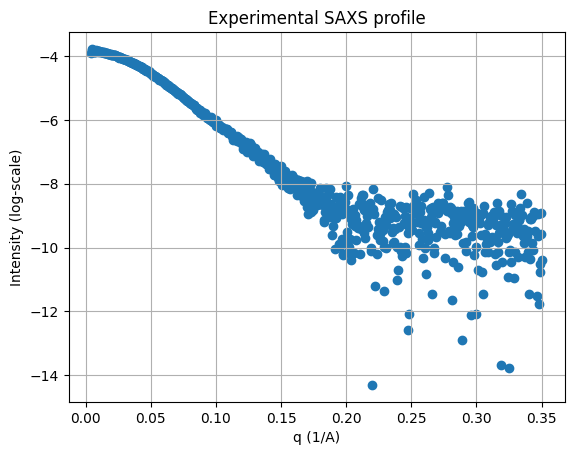

In [24]:
#@title Upload a SAXS profile file

uploaded_profile = None
uploaded_profile = files.upload()
uploaded_profile = uploaded_profile.keys()
if len(uploaded_profile) > 1:
    raise ValueError("Please upload a single profile file")
uploaded_profile = list(uploaded_profile)[0]
print(uploaded_profile)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io

# Define a custom function to filter lines
def filter_lines(line):
    try:
        float(line.split()[0])
        return True
    except ValueError:
        return False

with open(uploaded_profile, 'r') as file:
    filtered_lines = [line for line in file if filter_lines(line)]

data = pd.read_csv(io.StringIO(''.join(filtered_lines)), delimiter='\t', header=None, names=['Column1', 'Column2', 'Column3'])

#data = pd.read_csv(uploaded_profile, delimiter='\t', header=None, names=['Column1', 'Column2', 'Column3'])
data['Column2'] = data['Column2'].apply(lambda x: np.log(x) if x > 0 else 0)
plt.scatter(data['Column1'], data['Column2'])
plt.xlabel('q (1/A)')
plt.ylabel('Intensity (log-scale)')
plt.title('Experimental SAXS profile')
plt.grid(True)
plt.show()

In [17]:
!foxs SASDJW5.dat /content/Results/nb/nb_rank_?_relaxed.pdb

begin read_pdb:
  WARNING  No atoms were read from SASDJW5.dat; perhaps it is not a PDB file.
end read_pdb
WARNING  Negative intensity value: 1.86025763397E-01	-9.42280E-05	6.47387E-05 skipping remaining profile points
WARNING  Negative intensity value: 2.08348482324E-01	-3.03448E-05	6.92305E-05 skipping remaining profile points
WARNING  Negative intensity value: 2.09259484086E-01	-1.56701E-05	7.00053E-05 skipping remaining profile points
WARNING  Negative intensity value: 2.21556954489E-01	-1.28302E-05	6.52364E-05 skipping remaining profile points
WARNING  Negative intensity value: 2.22012377885E-01	-6.62545E-05	6.52983E-05 skipping remaining profile points
WARNING  Negative intensity value: 2.22923216263E-01	-2.13800E-05	6.51622E-05 skipping remaining profile points
WARNING  Negative intensity value: 2.37950389896E-01	-6.73185E-05	6.23454E-05 skipping remaining profile points
WARNING  Negative intensity value: 2.40226954133E-01	-2.92810E-05	6.22493E-05 skipping remaining profile poin

       Column1   Column2   Column3   Column4
0     0.004105 -3.906871  0.003562 -3.851461
1     0.004561 -3.825148  0.001282 -3.852473
2     0.005017 -3.779654  0.000825 -3.853507
3     0.005473 -3.803169  0.000578 -3.855088
4     0.005929 -3.837356  0.000488 -3.856672
...        ...       ...       ...       ...
1086  0.498178 -8.381963  0.000113 -9.825231
1087  0.498631  0.000000  0.000112 -9.827082
1088  0.499083 -8.257332  0.000114 -9.828751
1089  0.499536 -9.033283  0.000114 -9.830609
1090  0.499989 -8.372790  0.000113 -9.832284

[1091 rows x 4 columns]


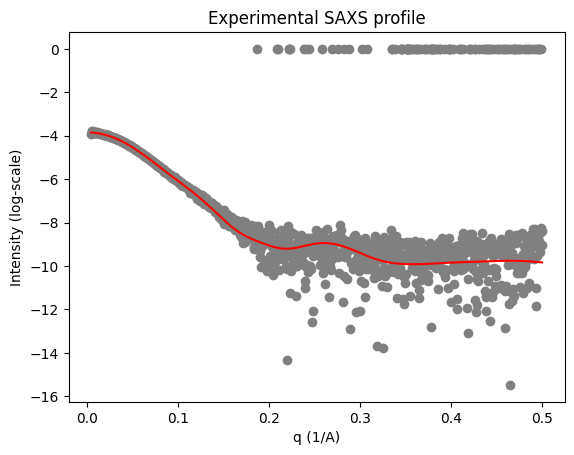

In [42]:
#@title Plot SAXS fits

with open("/content/Results/nb/nb_rank_1_relaxed_SASDJW5.fit", 'r') as file:
    filtered_lines = [line for line in file if filter_lines(line)]

data = pd.read_csv(io.StringIO(''.join(filtered_lines)), delimiter=r'\s+', names=['Column1', 'Column2', 'Column3','Column4'])
data['Column2'] = data['Column2'].apply(lambda x: np.log(x) if x > 0 else 0)
data['Column4'] = data['Column4'].apply(lambda x: np.log(x) if x > 0 else 0)

plt.scatter(data['Column1'], data['Column2'], color='gray')
plt.plot(data['Column1'], data['Column4'], color='red')
plt.xlabel('q (1/A)')
plt.ylabel('Intensity (log-scale)')
plt.title('Experimental SAXS profile')
plt.show()